In [1]:
#STEP 1 IMPORT

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pandas_profiling
import itertools

from sklearn.feature_selection import f_classif, mutual_info_classif
from pandas import Series
from datetime import datetime 
from collections import Counter
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, precision_score, brier_score_loss
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, f1_score, log_loss, average_precision_score
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn.model_selection import GridSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

Описания полей

    client_id - идентификатор клиента
    education - уровень образования
    sex - пол заемщика
    age - возраст заемщика
    car - флаг наличия автомобиля
    car_type - флаг автомобиля иномарки
    decline_app_cnt - количество отказанных прошлых заявок
    good_work - флаг наличия “хорошей” работы
    bki_request_cnt - количество запросов в БКИ
    home_address - категоризатор домашнего адреса
    work_address - категоризатор рабочего адреса
    income - доход заемщика
    foreign_passport - наличие загранпаспорта
    sna - связь заемщика с клиентами банка
    first_time - давность наличия информации о заемщике
    score_bki - скоринговый балл по данным из БКИ
    region_rating - рейтинг региона
    app_date - дата подачи заявки
    default - флаг дефолта по кредиту

In [3]:
#STEP 2 ЧТЕНИЕ ДАННЫХ
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')
df_train

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,0
73795,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,0
73796,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,0
73797,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1


# FUNCTION

In [4]:
# check IQR
def iqr(dt, cl, pr=None):
    IQR = dt.loc[:, cl].quantile(0.75) - dt.loc[:, cl].quantile(0.25)
    perc25 = dt.loc[:, cl].quantile(0.25)
    perc50 = dt.loc[:, cl].quantile(0.50)
    perc75 = dt.loc[:, cl].quantile(0.75)
    lb = perc25 - 1.5*IQR
    hb = perc75 + 1.5*IQR

    if pd.isnull(pr):
        return [IQR, perc25, perc50, perc75, lb, hb, dt.loc[:, cl].max(), dt.loc[:, cl].min(), cl]
    else:
        print(cl,
              '25-й перцентиль: {},'.format(perc25),
              '50-й перцентиль: {},'.format(perc50),
              '75-й перцентиль: {},'.format(perc75),
              "IQR: {}, ".format(IQR),
              "Границы выбросов: [{lb}, {hb}].".format(lb=lb, hb=hb))

In [5]:
# plot one hist to check outliers closer or just to look deeper

# tit - hist title
# rhb - reviewed highest border in 'Здравый смысл'
# rlb - reviewed lowest border in 'Здравый смысл'
# one of rhb or rlb could be missed

def hist_check(dth, tit, b=20, rhb=None, rlb=None):
    IQR = dth.quantile(0.75) - dth.quantile(0.25)
    perc25 = dth.quantile(0.25)
    perc50 = dth.quantile(0.5)
    perc75 = dth.quantile(0.75)
    lb = perc25 - 1.5*IQR
    hb = perc75 + 1.5*IQR

    print(
        '25-й перцентиль: {},'.format(perc25),
        '50-й перцентиль: {},'.format(perc50),
        '75-й перцентиль: {},'.format(perc75),
        "IQR: {}, ".format(IQR),
        "Границы выбросов: [{lb}, {hb}].".format(lb=lb, hb=hb))
    
    print("max value = {mx}\nmin value = {mn}\n".format(mx = max(dth),mn = min(dth)))

    fig = plt.figure()
    dth.loc[dth.between(
        lb,
        hb)].hist(bins=b, label='IQR')

    if rlb != None and rhb != None:
        dth.loc[(rlb <= dth) & (dth <= rhb)].hist(
            alpha=0.5, bins=b,  label='Здравый смысл')
    elif pd.isnull(rlb) and rhb != None:
        dth.loc[dth <= rhb].hist(
            alpha=0.5, bins=b,  label='Здравый смысл')
    elif pd.isnull(rhb) and rlb != None:
        dth.loc[rlb <= dth].hist(
            alpha=0.5, bins=b,  label='Здравый смысл')

    plt.legend()
    plt.title(tit)
    return [lb, hb]

In [6]:
def pre_model(data, submission = False):
    train_data = data.query('sample == 1').drop(['sample'], axis=1)
    test_data = data.query('sample == 0').drop(['sample'], axis=1)
    
    prediction = test_data.copy()
    
    train_data.drop('client_id', axis=1, inplace=True)
    test_data.drop('client_id', axis=1, inplace=True)

    y = train_data.default.values            # наш таргет
    X = train_data.drop(['default'], axis=1)

    RANDOM_SEED = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

    logModel = LogisticRegression(max_iter = 10000)
    logModel.fit(X_train, y_train)
    y_pred = logModel.predict(X_test)

    probs = logModel.predict_proba(X_test)
    prob = probs[:,1]
    
    scores(y_test, y_pred, prob)
    
    if submission:
        submission_ = pd.concat([prediction.client_id,pd.Series(prob,name='default')],axis=1)
        submission_.to_csv('submission.csv', index=False)
    
    return (roc_auc, submission_)

In [7]:
# calculating scores function
def scores(y_test, y_pred, prob):
    fpr, tpr, threshold = roc_curve(y_test, prob)
    roc_auc = roc_auc_score(y_test, prob)
    
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    print ("f1_score:",round(f1_score(y_test,y_pred), 5))
    print ("accuracy_score:",round(accuracy_score(y_test,y_pred), 5))
    print ("precision_score:",round(precision_score(y_test,y_pred), 5))
    print ("recall_score:",round(recall_score(y_test,y_pred), 5))
    print ("log_loss:",round(log_loss(y_test,y_pred), 5))
    print ("roc_auc_score:",round(roc_auc, 5))
    print("average_precision_score:", round(average_precision_score(y_test,y_pred), 5))
    print("brier_score_loss:", round(brier_score_loss(y_test,y_pred), 5))
    print('Confusion matrix:\n{}' .format(confusion_matrix(y_test,y_pred)))
    return (roc_auc)

# EDA

In [8]:
df_train.info()
# education содержит пустые значения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [10]:
#STEP 3 объединяем обучающий и тестовый набор

# заполним пока в целевую функцию 0
df_test['default'] = 0

# создадим столбец чтобы различать обучающую и тестовый набор
df_train['sample'] = 1
df_test['sample'] = 0

# объединяем обучающий и тестовый набор, чтобы применять одинаковую обработку 
data = df_test.append(df_train, sort=False).reset_index(drop=True)
data.head()
data.shape

(110148, 20)

In [11]:
# закачаем pandas profiling report
#data_rep = pandas_profiling.ProfileReport(data) 
#data_rep.to_file('data_report.html')
#на каггле не отрабатывает, виснит на 70%. Поэтому отчет запустила в юпитере

1. В базе достаточно мало пропущенных значени (< 0.1)

2. client_id - числовой, все значения уникальны, можно удалить
3. app_date - чаще всего повторяются 5 дат: 18MAR2014, 19MAR2014, 17MAR2014, 31MAR2014, 07APR2014
4. education - имеет пропуски 478 значений (0.4%), половина из которых SCH, можно им и заполнить пропуски
5. sex - бинарный, без пропусков
6. age - числовой, с правым хвостом. МОжно прологорифмировать, чтобы привести к нормальному распределению
7. car - бинарный, сильно связан с car_type
8. car_type - бинарный, сильно связан с car. Попробовать убрать один из (car, car_type)
9. decline_app_cnt - 83% имеют значение 0, можно попробовать редкие значения заменить правой границей выбороса
10. good_work - бинарный, без пропусков
11. score_bki - имеет нормальное распределение, отрицательные значения
12. bki_request_cnt - 26.2% имеют значение 0, можно попробовать редкие значения заменить правой границей выбороса
13. region_rating - по названию ординарный, без пропусков
14. home_address - категориальный, сильно связан с work_address
15. work_address - категориальный, сильно связан с home_address.  Попробовать убрать один из (home_address, work_address)
16. income - числовой, с выбросами (экстремально низкими и высокими значениями). Попробуем сделать производный столбец с категорией. Выбросы заменить на границы.
17. sna  - категориальный, сильно связан с first_time
18. first_time  - категориальный, сильно связан с sna.  Попробовать убрать один из (sna, first_time)
19. foreign_passport - бинарный
20. default - категориальный, целевой. 0	 91.5%. Дибаланс выборки, требуется underfitting/overfitting

In [12]:
# step 4
#client_id - идентификатор клиента
#education - уровень образования
#sex - пол заемщика
#age - возраст заемщика
#car - флаг наличия автомобиля
#car_type - флаг автомобиля иномарки
#decline_app_cnt - количество отказанных прошлых заявок
#good_work - флаг наличия “хорошей” работы
#bki_request_cnt - количество запросов в БКИ
#home_address - категоризатор домашнего адреса
#work_address - категоризатор рабочего адреса
#income - доход заемщика
#foreign_passport - наличие загранпаспорта
#sna - связь заемщика с клиентами банка
#first_time - давность наличия информации о заемщике
#score_bki - скоринговый балл по данным из БКИ
#region_rating - рейтинг региона
#app_date - дата подачи заявки
# бинарные переменные - имеют 2 значения
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные 
cat_cols = ['home_address', 'work_address', 'sna','first_time']
# числовые переменные
num_cols_p1 = ['age', 'decline_app_cnt','income','bki_request_cnt']
num_cols_p2 = ['score_bki']
# ординарные переменные - ранжируются
ord_cols = ['education','region_rating']

# РАБОТАЕМ С БИНАРНЫМИ ПЕРЕМЕННЫМИ

In [13]:
# step 5
# Применим LabelEncoder ко всему набору бинарных переменных.
# bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,74835,22MAR2014,GRD,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,0
1,17527,24JAN2014,SCH,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,0,0
2,75683,23MAR2014,UGR,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0,0
3,26883,03FEB2014,SCH,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,0,0
4,28862,04FEB2014,GRD,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,0,0


# РАБОТАЕМ С КАТЕГОРИАЛЬНЫМИ ПЕРЕМЕННЫМИ

sex                 0.000106
car                 0.000630
good_work           0.000662
car_type            0.001181
foreign_passport    0.001578
work_address        0.002271
home_address        0.002808
first_time          0.003558
sna                 0.004829
dtype: float64

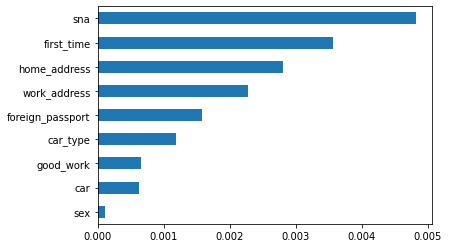

In [14]:
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
imp_cat

In [15]:
# step 6 категориальные переменные 
#cat_cols = ['home_address', 'work_address', 'sna', 'first_time', 'day_week', 'is_weekend']
#для One-Hot Encoding в pandas функция - get_dummies для преобразования категориальных переменных
data = pd.get_dummies(data, columns = cat_cols, dummy_na=False) ## 0.7395056692123537 - 0.7423124806722499

In [16]:
# step 7
# app_date попробуем поработать с ней
data['app_date'] = data['app_date'].apply(lambda x: pd.to_datetime(x, format='%d%b%Y').date())
data['day_week'] = data['app_date'].apply(lambda x: x.isoweekday()) #день недели в виде числа, понедельник - 1, воскресенье - 7 слабая значимость уберу пока
#data['is_weekend'] = np.where(data['day_week'].isin([6,7]), 1 , 0)  #слабая значимость уберу пока
#cat_cols = cat_cols + ['day_week','is_weekend']
cat_cols = cat_cols + ['day_week']
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,day_week
0,74835,2014-03-22,GRD,1,29,1,1,0,0,-2.271884,...,0,1,0,0,0,0,0,0,1,6
1,17527,2014-01-24,SCH,0,39,0,0,5,0,-1.504999,...,0,0,0,0,1,0,0,1,0,5
2,75683,2014-03-23,UGR,1,50,1,1,0,0,-1.691339,...,0,1,0,0,0,0,0,1,0,7
3,26883,2014-02-03,SCH,1,56,0,0,0,0,-2.374182,...,0,1,0,0,0,0,0,1,0,1
4,28862,2014-02-04,GRD,0,38,0,0,0,0,-2.487502,...,1,1,0,0,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,2014-03-04,GRD,0,45,0,0,0,0,-1.792064,...,0,0,0,0,1,0,0,0,1,2
110144,76821,2014-03-24,SCH,1,41,1,1,0,0,-2.058029,...,0,1,0,0,0,0,0,0,1,1
110145,103695,2014-04-22,SCH,1,31,0,0,0,0,-1.512635,...,1,0,1,0,0,0,1,0,0,2
110146,861,2014-01-04,SCH,0,29,0,0,0,1,-1.479334,...,1,0,1,0,0,0,0,1,0,6


# РАБОТАЕМ С ЧИСЛОВЫМИ ПЕРЕМЕННЫМИ

In [17]:
# проверим выбросы
al = []
for col in num_cols_p1 + num_cols_p2:
    al.append(iqr(data, col))
    
# find columns with outliers => NaN in outlier column
all_borders = pd.DataFrame(al, columns=['IQR', 'perc25', 'perc50' , 'perc75', 'lb', 'hb', 'max_v', 'min_v', 'df_train'])
all_borders.loc[(all_borders.hb >= all_borders.max_v) & (all_borders.lb <= all_borders.min_v), 'outlier'] = 'no'
all_borders['outlier'].fillna('yes', inplace=True)
all_borders

# выбросы есть, вернемся к ним позже

,IQR,perc25,perc50,perc75,lb,hb,max_v,min_v,df_train,outlier
0,18.000000,30.000000,37.000000,48.000000,3.000000,75.00000,72.000000,21.000000,age,no
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,33.000000,0.000000,decline_app_cnt,yes
2,28000.000000,20000.000000,30000.000000,48000.000000,-22000.000000,90000.00000,1000000.000000,1000.000000,income,yes
3,3.000000,0.000000,1.000000,3.000000,-4.500000,7.50000,53.000000,0.000000,bki_request_cnt,yes
4,0.692546,-2.260434,-1.920823,-1.567888,-3.299252,-0.52907,0.199773,-3.624586,score_bki,yes


## Числовая переменная - decline_app_cnt

25-й перцентиль: 0.0, 50-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].
max value = 33
min value = 0



[0.0, 0.0]

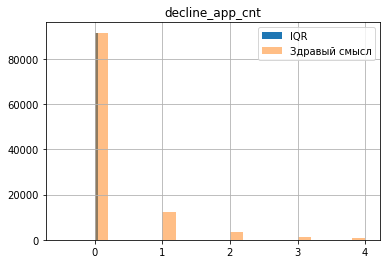

In [18]:
# посмотрим на выбросы
col_name = 'decline_app_cnt'
hist_check(data[col_name], tit = col_name, rhb = 4)

In [19]:
# работаем с выбросами
# 1 вариант - удаление больше 10 значений;
# 2 вариант - заменить крайние значением 10
# 3 вариант - ввести диапазоны
#data = data.loc[data['decline_app_cnt'].isin(data['decline_app_cnt'].value_counts().iloc[:10].index)]  # (0.7390304398599137 -> 0.7390304398599137) никак не поменяло
#data[data['decline_app_cnt'].isin(data['decline_app_cnt'].value_counts().iloc[10:].index)] = 10 # (0.7390304398599137 -> 0.7192089210380366) ухудшило сильно

#bins = [-np.inf, 0, 0.5, 1, 3, 7, np.inf] # 0.7390304398599137 - 0.738750990272759 дала ухудшение точности модели

bins = [ -np.inf, 0, 1, np.inf] # 0.7390304398599137 - 0.7390712802130266  хорошо подобранная категоризация дает повышение точности модели
#в категорию должно попадать примерно 10% выборки - тогда ОК
labels=[0,1,2]
data['decline_app_cnt_cut'] = pd.cut(data['decline_app_cnt'], bins=bins, labels=labels)

## Числовая переменная - income

25-й перцентиль: 20000.0, 50-й перцентиль: 30000.0, 75-й перцентиль: 48000.0, IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
max value = 1000000
min value = 1000



[-22000.0, 90000.0]

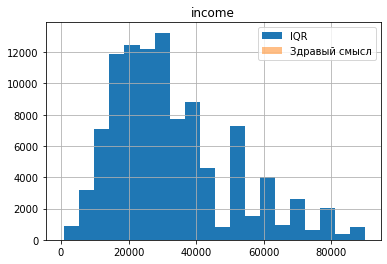

In [20]:
# посмотрим на выбросы
col_name = 'income'
hist_check(data[col_name], tit = col_name, rhb = 4)

In [21]:
# работаем с выбросами 
#удаление редких значние частота < 100 # 0.739228124097624 - 0.7379307112463617 удаление делает все хуже
#data = data.loc[data['income'].isin(data['income'].value_counts().loc[lambda x: x > 100].index)]  
#[[12076    41]
# [ 1755    34]]

# удаление только выброса 0.739228124097624 - 0.7260857711029212 удаление делает все хуже
#borders = pd.DataFrame(iqr(data, 'income')).T
#borders.columns = ['IQR', 'perc25', 'perc50', perc75', 'lb', 'hb', 'max_v', 'min_v', 'df_train']
#data = data[(data['income'] >= borders.lb[0]) &  (data['income'] <= borders.hb[0])]

bins = [ -np.inf, 20000, 30000, 48000, np.inf] # 0.7390712802130266 - 0.739228124097624 категории соответствуют квартилям до логорифма
labels=[0,1,2,4]
data['income_cut'] = pd.cut(data['income'], bins=bins, labels=labels)

## Числовая переменная - bki_request_cnt

25-й перцентиль: 0.0, 50-й перцентиль: 1.0, 75-й перцентиль: 3.0, IQR: 3.0,  Границы выбросов: [-4.5, 7.5].
max value = 53
min value = 0



[-4.5, 7.5]

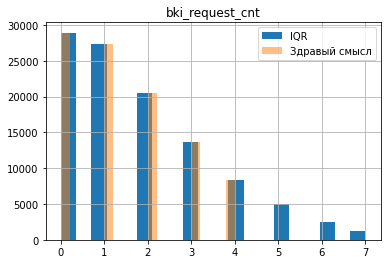

In [22]:
# посмотрим на выбросы
col_name = 'bki_request_cnt'
hist_check(data[col_name], tit = col_name, rhb = 4)

In [23]:
# работаем с выбросами
bins = [ -np.inf, 0, 1, 3, np.inf] # 0.739228124097624 категории соответствуют квартилям до логорифма
labels=[0,1,2,4]
data['bki_request_cnt_cut'] = pd.cut(data['bki_request_cnt'], bins=bins, labels=labels) # 0.739228124097624  - 0.7392577492242344

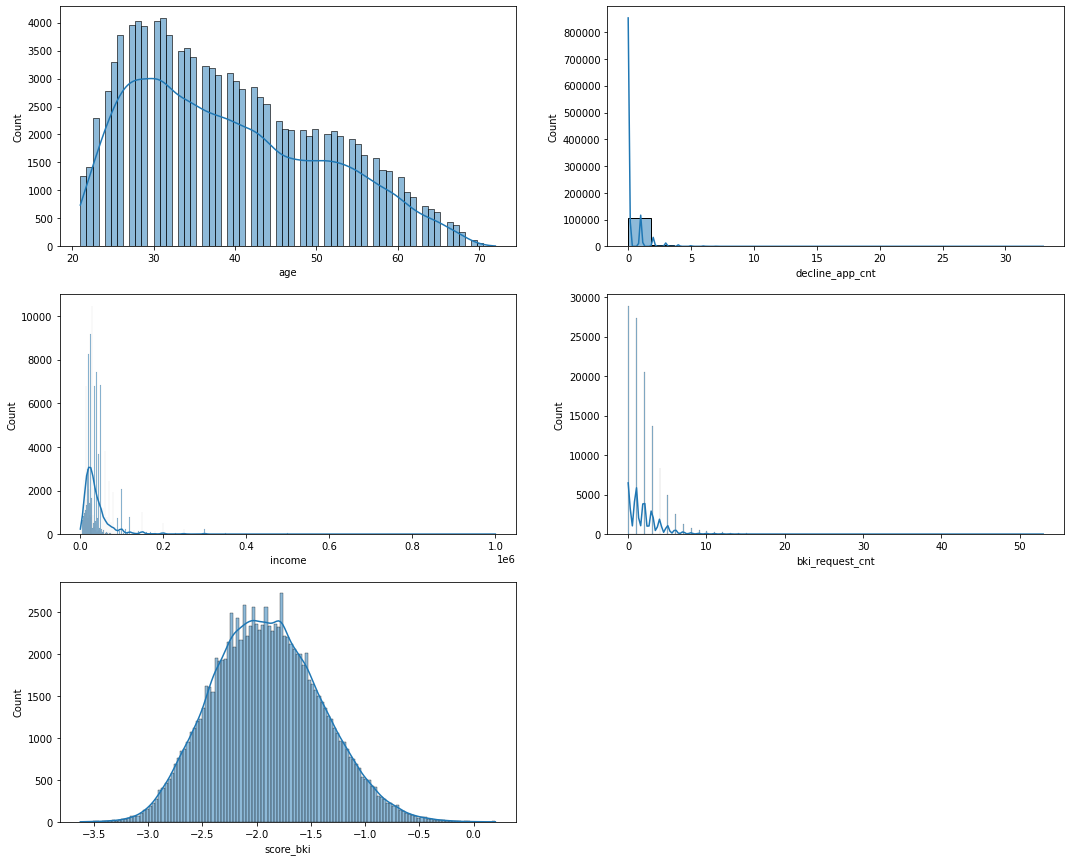

In [24]:
fig=plt.figure(figsize=(18, 15))
columns = 2
rows = 3
for i,col in enumerate(num_cols_p1 + num_cols_p2):
    fig.add_subplot(rows, columns, i+1)
    sns.histplot(data[col], kde=True)

In [25]:
# step 7
# теперь задача прологорифмировать числовые переменные, со 'score_bki' поработаем отдельно
data[num_cols_p1] = data[num_cols_p1].apply(lambda w: np.log(w + 1))
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,day_week,decline_app_cnt_cut,income_cut,bki_request_cnt_cut
0,74835,2014-03-22,GRD,1,3.401197,1,1,0.000000,0,-2.271884,...,0,0,0,0,0,1,6,0,4,2
1,17527,2014-01-24,SCH,0,3.688879,0,0,1.791759,0,-1.504999,...,0,1,0,0,1,0,5,2,0,2
2,75683,2014-03-23,UGR,1,3.931826,1,1,0.000000,0,-1.691339,...,0,0,0,0,1,0,7,0,1,1
3,26883,2014-02-03,SCH,1,4.043051,0,0,0.000000,0,-2.374182,...,0,0,0,0,1,0,1,0,0,1
4,28862,2014-02-04,GRD,0,3.663562,0,0,0.000000,0,-2.487502,...,0,0,0,0,1,0,2,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,2014-03-04,GRD,0,3.828641,0,0,0.000000,0,-1.792064,...,0,1,0,0,0,1,2,0,0,2
110144,76821,2014-03-24,SCH,1,3.737670,1,1,0.000000,0,-2.058029,...,0,0,0,0,0,1,1,0,4,1
110145,103695,2014-04-22,SCH,1,3.465736,0,0,0.000000,0,-1.512635,...,0,0,0,1,0,0,2,0,2,4
110146,861,2014-01-04,SCH,0,3.401197,0,0,0.000000,1,-1.479334,...,0,0,0,0,1,0,6,0,0,2


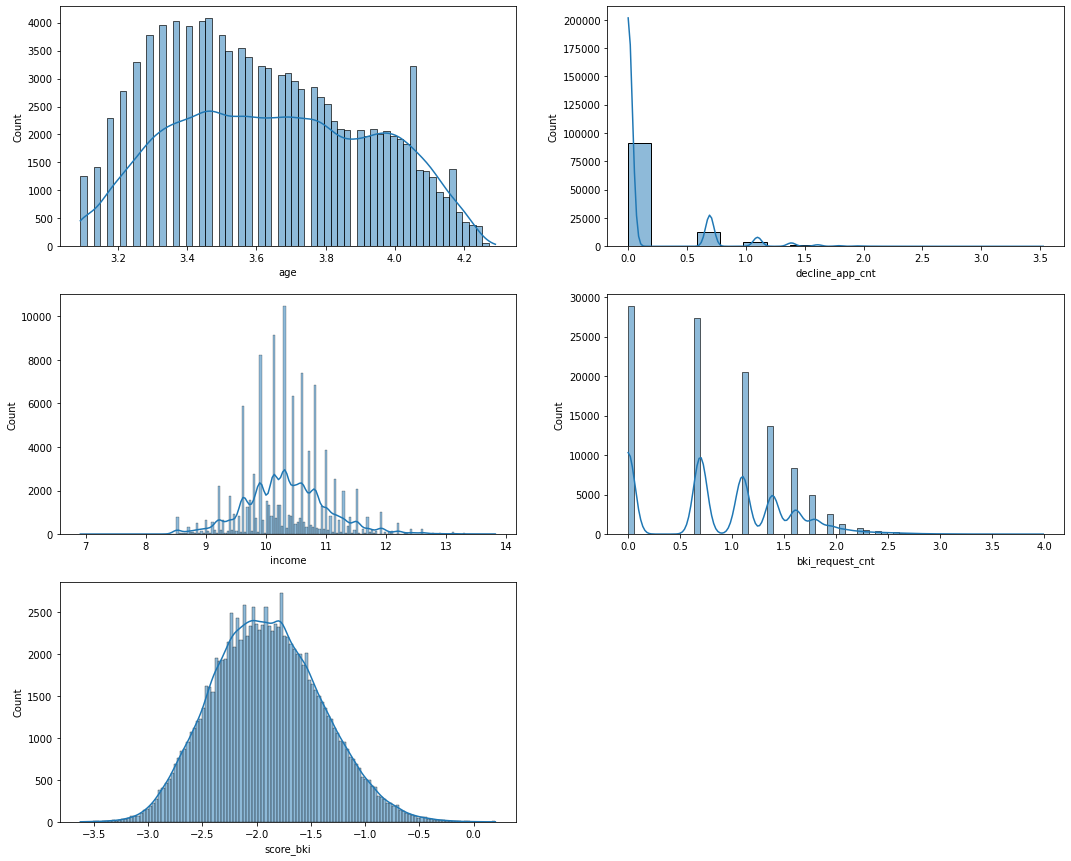

In [26]:
fig=plt.figure(figsize=(18, 15))
columns = 2
rows = 3
for i,col in enumerate(num_cols_p1 + num_cols_p2):
    fig.add_subplot(rows, columns, i+1)
    sns.histplot(data[col], kde=True)

## Числовая переменная - score_bki

25-й перцентиль: -2.2604336700000003, 50-й перцентиль: -1.92082293, 75-й перцентиль: -1.5678881525, IQR: 0.6925455175000004,  Границы выбросов: [-3.299251946250001, -0.5290698762499992].
max value = 0.19977285
min value = -3.62458632



[-3.299251946250001, -0.5290698762499992]

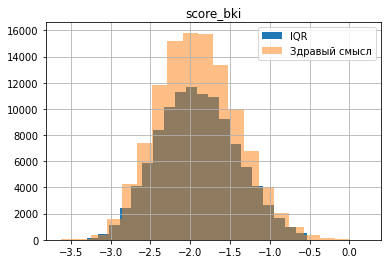

In [27]:
# посмотрим на выбросы
col_name = 'score_bki'
hist_check(data[col_name], tit = col_name, rhb = 4)

In [28]:
# работаем с выбросами
borders = pd.DataFrame(iqr(data, 'score_bki')).T
borders.columns = ['IQR', 'perc25', 'perc50', 'perc75', 'lb', 'hb', 'max_v', 'min_v', 'df_train']

#bins = [ -np.inf, borders.perc25[0], borders.perc50[0], borders.perc75[0], np.inf] #  категории соответствуют квартилям до логорифма 0.7392577492242344
bins = [ -np.inf, -2.26, -1.92, -1.57, np.inf] 
labels=[0,1,2,4]
data['score_bki_cut'] = pd.cut(data['score_bki'], bins=bins, labels=labels) 

In [29]:
# step 8
# поработаем со 'score_bki'  отдельно
#data['score_bki_abs'] = data['score_bki'].apply(lambda w: np.log(abs(w) + 1)) # возьмем по модулю - ухудшает показатель модели, не берем
#data['score_bki_pow'] = data['score_bki'].apply(lambda w: w ** 2) # возьмем квадрат - ухудшает показатель модели, не берем
#data

# РАБОТАЕМ С ОРДИНАРНЫМИ ПЕРЕМЕННЫМИ

UNK - неизвестно 0 ровень
SCH - школа - 1 уровень
UGR - undergraduated - бакалавриат - 2 уровень
GRD - graduated - магистр, высшее образование - 3 уровень
PGR - postgraduated- аспирантура - 4 уровень
ACD - academic - докторантура - 5 уровень. 

In [30]:
#STEP 9 
# ординарные переменные - ранжируются
# ord_cols = ['education','region_rating']

#education
#пропуски только в поле education, заполним категорие = неизвестно 'UNK'
data['education'].fillna('UNK', inplace=True)

edu = {'SCH': 1, 'UGR': 2, 'GRD': 3,  'PGR': 4, 'ACD': 5, 'UNK':0}
data['education'] = data['education'].map(edu)

In [31]:
data.corr().default.sort_values()

sna_1              -0.092895
home_address_1     -0.073097
region_rating      -0.071729
education          -0.066674
first_time_4       -0.063273
foreign_passport   -0.052770
car_type           -0.046586
work_address_1     -0.044087
income             -0.043099
work_address_2     -0.037375
good_work          -0.035126
car                -0.034999
client_id          -0.030812
age                -0.020045
first_time_3       -0.013500
home_address_3     -0.003282
day_week            0.000546
sex                 0.014580
sna_3               0.017906
sna_2               0.022717
first_time_2        0.029596
bki_request_cnt     0.062350
work_address_3      0.062800
first_time_1        0.063061
home_address_2      0.073700
sna_4               0.088839
decline_app_cnt     0.100564
score_bki           0.139777
sample              0.214022
default             1.000000
Name: default, dtype: float64

<AxesSubplot:>

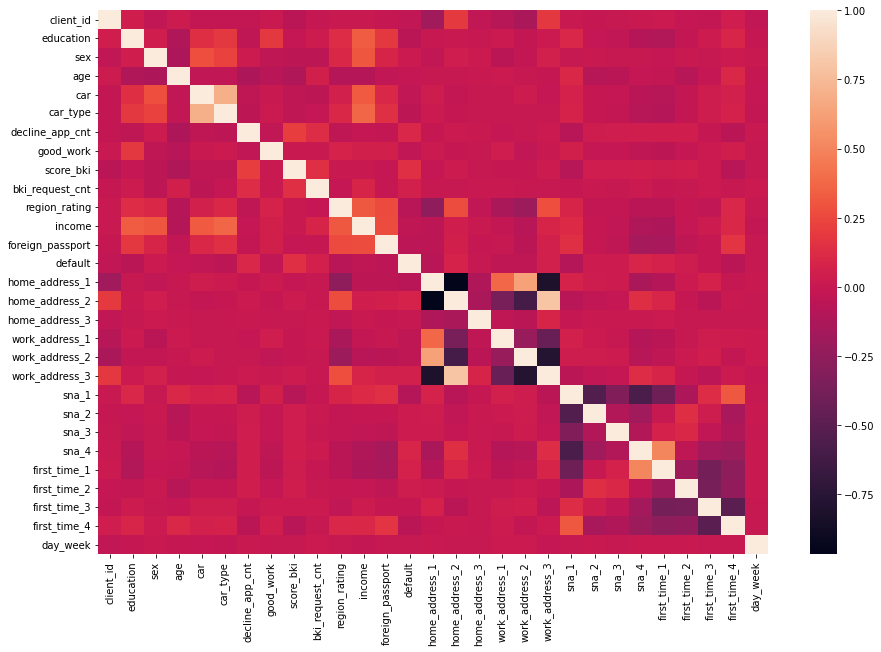

In [32]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr())

# СОЗДАНИЕ НОВЫХ СТОЛБЦОВ

In [33]:
# тут все неудачные комбанации
#data['ed_inc'] = data['education'] * data['income'] # 0.743179142590432 - 0.7431815549221703 = 0,0000024123317379221 (corr )
#data['dec_ap_score_reg'] = data['decline_app_cnt'] * data['score_bki']/data['region_rating'] # 0.743179142590432 - 0.7431552732027061 = -0,0000262817194639497 (-0.081692)
#data['dec_ap_bki_req_reg'] = data['decline_app_cnt'] * data['bki_request_cnt']/data['region_rating'] # 0.743179142590432 - 0.7431937012240806 = 0,0000121463019100432(corr 0.098508)
#data['score_bki_req_reg'] = data['score_bki'] * data['bki_request_cnt']/data['region_rating'] # 0.743179142590432 - 0.7432295899488887 = 0,0000480350267180185 (corr -0.024485)
#data['mean_requests_income'] = data.groupby('income')['bki_request_cnt'].transform('mean') # 0.743179142590432 - 0.7431762223993805 = -5,33252279000251E-06(corr 0.011742)
#data['bki_age_reg'] = (data['score_bki']/data['age'])*data['region_rating'] # 0.743179142590432 - 0.7431988221388233 = 0,0000172672166530718 (corr 0.139786)
#data['reg_rat_mean_inc'] = data.groupby('region_rating')['income'].transform('mean') # 0.743179142590432 - 0.7432846080411649 = 0,000103053118994056 (cor -0.068666)

#data['norm_inc_age'] = data.income / data.mean_income_age # 0.743179142590432 -  0.7433265910777329 = 0,000145036155562051, 0.7436014276094582 ('mean_income_age' + 'norm_inc_age')
#data['reg_rat_inc'] = data['income'] / data['region_rating'] # 0.743179142590432 - 0.7432964580918091 = 0,000114903169639025 (corr 0.058951)

#data['mean_bki_dec'] = data.groupby('decline_app_cnt')['score_bki'].transform('mean') # 0.743179142590432 - 0.7431960712342095 = 0,0000145163120390812 (corr 0.100125)
#data['mean_bki_inc'] = data.groupby('income')['score_bki'].transform('mean') # 0.743179142590432 - 0.743259299718718 = 0,0000777447965479849 (corr 0.021108)
#data['mean_bki_rec'] = data.groupby('bki_request_cnt')['score_bki'].transform('mean') # 0.743179142590432 - 0.7426825831468328 = -0,000498971775337975 (corr 0.061864)
#data['mean_income_dec'] = data.groupby('decline_app_cnt')['income'].transform('mean') # 0.743179142590432 - 0.7432069478878363 = 0,0000253929656660601 (cor -0.068973)
#data['mean_income_req'] = data.groupby('bki_request_cnt')['income'].transform('mean') # 0.743179142590432 - 0.7432914218202854 = 0,000109866898114985 (corr 0.051777)
#data['mean_income_bki'] = data.groupby('score_bki')['income'].transform('mean') # 0.743179142590432 - 0.7431630603788435 = -0,000018494543326919 (corr -0.042884)
#data['mean_dec_inc'] = data.groupby('income')['decline_app_cnt'].transform('mean') # 0.743179142590432 - 0.7430657206771238 = -0,00011583424504702 (cor -0.068973)
#data['mean_dec_req'] = data.groupby('bki_request_cnt')['decline_app_cnt'].transform('mean') # 0.743179142590432 - 0.7430233144244613 = -0,000158240497708961 (corr 0.051777)
#data['mean_req_age'] = data.groupby('age')['bki_request_cnt'].transform('mean') # 0.743179142590432 - 0.7432366999792752 = 0,0000551450571050216 
#data['mean_req_dec'] = data.groupby('decline_app_cnt')['bki_request_cnt'].transform('mean') # 0.743179142590432 - 0.7431813433141232 = -2,11608046973843E-07  
#data['mean_req_inc'] = data.groupby('income')['bki_request_cnt'].transform('mean') # 0.743179142590432 - 0.7431640760974701 = -0,0000181559704509615  
#data['mean_req_bki'] = data.groupby('score_bki')['bki_request_cnt'].transform('mean') # 0.743179142590432 - 0.7431925585406257 = 0,0000110036184550744  
#data['mean_age_dec'] = data.groupby('decline_app_cnt')['age'].transform('mean') # 0.743179142590432 - 0.7432037314455187 = 0,0000221765233480165 
#data['mean_age_inc'] = data.groupby('income')['age'].transform('mean') # 0.743179142590432 - 0.7432624315178167 = 0,00008087659564604
#data['mean_age_req'] = data.groupby('bki_request_cnt')['age'].transform('mean') # 0.743179142590432 - 0.743231452099704 = 0,0000498971775340085
#data['mean_age_bki'] = data.groupby('score_bki')['age'].transform('mean') # 0.743179142590432 - 0.7431739370324706 = -7,61788969994015E-06 (corr -0.042884)


# СБАЛАНСИРОВАНИЕ МОДЕЛИ

In [34]:
#------------------------------------------------------------------------------
# STEP NN сбалансирование выборки
#n = train_data['default'].value_counts()[1]
#train_data_del_0 = train_data[train_data['default'] == 0].head(n) #n строк класса ['compliance'] == 0
#train_data = pd.concat([train_data_del_0, train_data[train_data['default'] == 1]]) #объединение класса 0 и 1 равного колва
#-------------------------------
#улучшенной моделью + сбалансирование выборки
#roc_auc 0.7415717353797848
#f1_score: 0.68152
#accuracy_score: 0.67965
#precision_score: 0.67313
#recall_score: 0.69012
#log_loss: 11.0647
#roc_auc_score: 0.74157
#average_precision_score: 0.61845
#brier_score_loss: 0.32035
#Confusion matrix:
#[[1263  624]
# [ 577 1285]]

#0.743179142590432 (исх) - 0.7415717353797848 так как roc_auc ухудшился - не буду делать

# CLEAR

In [35]:
#STEP 10 удаляем лишние колонки

# client_id 
# проверим, если нет повторений то врядли полезен
#data.client_id.value_counts().loc[lambda x: x > 1]
#повторений нет, наверно удалим пока
data.drop('client_id', axis=1, inplace=True)

# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

data

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,day_week,decline_app_cnt_cut,income_cut,bki_request_cnt_cut,score_bki_cut
0,3,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,50,...,0,0,0,0,1,6,0,4,2,0
1,1,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,50,...,1,0,0,1,0,5,2,0,2,4
2,2,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,50,...,0,0,0,1,0,7,0,1,1,2
3,1,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,40,...,0,0,0,1,0,1,0,0,1,0
4,3,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,80,...,0,0,0,1,0,2,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,3,0,3.828641,0,0,0.000000,0,-1.792064,1.386294,50,...,1,0,0,0,1,2,0,0,2,2
110144,1,1,3.737670,1,1,0.000000,0,-2.058029,0.693147,50,...,0,0,0,0,1,1,0,4,1,1
110145,1,1,3.465736,0,0,0.000000,0,-1.512635,1.609438,80,...,0,0,1,0,0,2,0,2,4,4
110146,1,0,3.401197,0,0,0.000000,1,-1.479334,1.386294,50,...,0,0,0,1,0,6,0,0,2,4


# РЕГУЛЯРИЗАЦИЯ

In [36]:
#найдем лучшие параметры для регуляризации

# Добавим типы регуляризации
#penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
#C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
#hyperparameters = dict(C=C, penalty=penalty)

#model = LogisticRegression(max_iter = 100000)
#model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
#clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

#best_model = clf.fit(X_train, y_train)

# View best hyperparameters
#print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
#print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

In [37]:
# код основного прогона, без всяких изысканий
# наивная модель 
#STEP 1 IMPORT + function (прогоняем в начале)

#STEP 2 ЧТЕНИЕ ДАННЫХ
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

#STEP 3 объединяем обучающий и тестовый набор
# заполним пока в целевую функцию 0
df_test['default'] = 0
# создадим столбец чтобы различать обучающую и тестовый набор
df_train['sample'] = 1
df_test['sample'] = 0
# объединяем обучающий и тестовый набор, чтобы применять одинаковую обработку 
data = df_test.append(df_train, sort=False).reset_index(drop=True)

# step 4
# бинарные переменные - имеют 2 значения
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные 
cat_cols = ['home_address', 'work_address', 'sna','first_time']
# числовые переменные
num_cols_p1 = ['age', 'decline_app_cnt','income','bki_request_cnt']
num_cols_p2 = ['score_bki']
# ординарные переменные - ранжируются
ord_cols = ['education','region_rating']

# step 5 бинарные переменные
# bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

# step 6 категориальные переменные 
#cat_cols = ['home_address', 'work_address', 'sna', 'first_time', 'day_week', 'is_weekend']
data['app_date'] = data['app_date'].apply(lambda x: pd.to_datetime(x, format='%d%b%Y').date())
data['day_week'] = data['app_date'].apply(lambda x: x.isoweekday()) #день недели в виде числа, понедельник - 1, воскресенье - 7 
cat_cols = cat_cols + ['day_week']

# step 7 числовые переменные
# num_cols_p1 = ['age', 'decline_app_cnt','income','bki_request_cnt']
# теперь задача прологорифмировать числовые переменные, со 'score_bki' поработаем отдельно
data[num_cols_p1] = data[num_cols_p1].apply(lambda w: np.log(w + 1))

#STEP 8 ординарные переменные - ранжируются
# ord_cols = ['education','region_rating']
#пропуски только в поле education, заполним категорие = неизвестно 'UNK'
data['education'].fillna('UNK', inplace=True)
edu = {'SCH': 1, 'UGR': 2, 'GRD': 3,  'PGR': 4, 'ACD': 5, 'UNK':0}
data['education'] = data['education'].map(edu)

#STEP 9 удаляем лишние колонки

object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

#roc_auc, submission  = pre_model(data, submission = True)
#roc_auc 0.7388534508892215 наивная модель,  0.7388629732513462(без даты) 0.5853445937593147(без логорифма) 
#0.7389893032555347 (только 'score_bki') 0.7385340073811426(только'score_bki_abs') 0.7378751868869371 (только 'score_bki_pow')


In [38]:
# наивная модель
# roc_auc 0.7390304398599137
#f1_score: 0.03958
#accuracy_score: 0.87507
#precision_score: 0.4086
#recall_score: 0.0208
#log_loss: 4.31501
#roc_auc_score: 0.73903
#average_precision_score: 0.1297
#brier_score_loss: 0.12493
#Confusion matrix:
#[[12878    55]
# [ 1789    38]]

# сравнение с улучшенной моделью
# roc_auc 0.7423124806722499
#f1_score: 0.04282
#accuracy_score: 0.87581
#precision_score: 0.46591
#recall_score: 0.02244
#log_loss: 4.28927
#roc_auc_score: 0.74231
#average_precision_score: 0.13146
#brier_score_loss: 0.12419
#Confusion matrix:
#[[12886    47]
# [ 1786    41]]

#улучшенной моделью + сбалансирование выборки
#roc_auc 0.7415717353797848
#f1_score: 0.68152
#accuracy_score: 0.67965
#precision_score: 0.67313
#recall_score: 0.69012
#log_loss: 11.0647
#roc_auc_score: 0.74157
#average_precision_score: 0.61845
#brier_score_loss: 0.32035
#Confusion matrix:
#[[1263  624]
# [ 577 1285]]

#улучшенной моделью + новые числовые колонки
#roc_auc 0.7447659066932938
#f1_score: 0.04569
#accuracy_score: 0.87547
#precision_score: 0.44444
#recall_score: 0.02408
#log_loss: 4.30097
#roc_auc_score: 0.74477
#average_precision_score: 0.1315
#brier_score_loss: 0.12453
#Confusion matrix:
#[[12878    55]
# [ 1783    44]]

#улучшенной моделью + новые числовые колонки+сбалансирование выборки + регуляризация
#roc_auc 0.7446144887542501
#f1_score: 0.68455
#accuracy_score: 0.68312
#precision_score: 0.677
#recall_score: 0.69227
#log_loss: 10.94493
#roc_auc_score: 0.74461
#average_precision_score: 0.6215
#brier_score_loss: 0.31688
#Confusion matrix:
#[[1272  615]
# [ 573 1289]]

In [39]:
# код основного прогона, без всяких изысканий
# эксперементальная модель, выберем лучшее 
#STEP 1 IMPORT + function (прогоняем в начале)

#STEP 2 ЧТЕНИЕ ДАННЫХ
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

#----------------------------
#STEP 3 объединяем обучающий и тестовый набор
# заполним пока в целевую функцию 0
df_test['default'] = 0
# создадим столбец чтобы различать обучающую и тестовый набор
df_train['sample'] = 1
df_test['sample'] = 0
# объединяем обучающий и тестовый набор, чтобы применять одинаковую обработку 
data = df_test.append(df_train, sort=False).reset_index(drop=True)

#-----------------------------------------------
# step 4
# бинарные переменные - имеют 2 значения
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные 
cat_cols = ['sna','first_time','home_address', 'work_address'] 
# числовые переменные
num_cols_p1 = ['age', 'decline_app_cnt','income','bki_request_cnt']
num_cols_p2 = ['score_bki']
num_cols = num_cols_p1 + num_cols_p2
# ординарные переменные - ранжируются
ord_cols = ['education','region_rating']

#--------------------------------------------------
# step 5 бинарные переменные
# bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

#---------------------------------------------------------
# step 6 числовые переменные
# num_cols_p1 = ['age', 'decline_app_cnt','income','bki_request_cnt']
# decline_app_cnt
bins = [-np.inf, 0, 1, np.inf] 
labels = [0,1,2]
data['decline_app_cnt_cut'] = pd.cut(data['decline_app_cnt'], bins=bins, labels=labels) 

bins = [ -np.inf, 20000, 30000, 48000, np.inf] 
labels = [0,1,2,4]
data['income_cut'] = pd.cut(data['income'], bins=bins, labels=labels)

bins = [ -np.inf, 0, 1, 3, np.inf] 
labels = [0,1,2,4]
data['bki_request_cnt_cut'] = pd.cut(data['bki_request_cnt'], bins=bins, labels=labels)

bins = [ -np.inf, -2.26, -1.92, -1.57, np.inf] 
labels=[0,1,2,4]
data['score_bki_cut'] = pd.cut(data['score_bki'], bins=bins, labels=labels)

# теперь задача прологорифмировать числовые переменные, со 'score_bki' поработаем отдельно
data[num_cols_p1] = data[num_cols_p1].apply(lambda w: np.log(w + 1))

#--------------------------------------------------------------------
#STEP 7 ординарные переменные - ранжируются
# ord_cols = ['education','region_rating']
#пропуски только в поле education, заполним категорие = неизвестно 'UNK'
data['education'].fillna('UNK', inplace=True)
edu = {'UNK':1,'SCH': 2, 'UGR': 3, 'GRD': 4,  'PGR': 5, 'ACD': 6}
data['education'] = data['education'].map(edu)

#----------------------------------------------------------------------
#STEP 8 создание новых колонок
# сложим сильно сколлерированные переменные
data['car_ct'] = data['car'] + data['car_type']
data['mult_address'] = data['home_address'] + data['work_address']

# mult_cat_col|ord_col 
data['sna_first_reg'] = data['sna'] * data['first_time']/data['region_rating'] # 0.743179142590432 - 0.7436427758218845 = 0,00046122089971401 (corr 0.074910)
data['sna_first_madr_reg'] = data['sna'] * data['first_time'] * data['mult_address'] /data['region_rating'] # 0.743179142590432 - 0.7438546801203677 = 0,00067312519819
data['sna_first_madr_edu'] = data['sna'] * data['first_time'] * data['mult_address'] /data['education'] # 0.743179142590432 -  0.7436665182447824 = 0,000484963322612053

#mean
data['mean_bki_age'] = data.groupby('age')['score_bki'].transform('mean') # 0.743179142590432 - 0.7438871407948109 = 0,000705585872640024 (corr 0.017395)
data['mean_income_age'] = data.groupby('age')['income'].transform('mean') # 0.743179142590432 - 0.743547086662933 = 0,000365531740763037 (corr 0.003030)
data['mean_dec_age'] = data.groupby('age')['decline_app_cnt'].transform('mean') # 0.743179142590432 - 0.743417751824474 = 0,000236196902304031 (cor -0.068973)
data['mean_dec_bki'] = data.groupby('score_bki')['decline_app_cnt'].transform('mean') # 0.743179142590432 - 0.7433973951303318 = 0,000215840208161011 (corr -0.042884)

num_cols_new = ['sna_first_reg', 'sna_first_madr_reg', 'sna_first_madr_edu', 'mean_bki_age', 'mean_income_age', 'mean_dec_age', 'mean_dec_bki']

# 0.7423124806722499 (без шага - создание новых колонок) - 0.7441523703211925 (создание новых колонок) - 0.7441929144230395 (убрали 'car','car_type' лучше)
#0.7416093917745665 (без get_dummies  'home_address', 'work_address' хуже) - 0.7437740997759875 (get_dummies 'mult_address') 
#0.7444168803802139 (get_dummies 'car_ct','mult_address' лучше) - 0.7431063917437988 (без кучи колонок) -0.7447659066932938 (со всемя новыми колонками и get_dummies)
#-------------------------------------------------------------------------------
# step 9 категориальные переменные 
#cat_cols = ['home_address', 'work_address', 'sna', 'first_time', 'day_week', 'is_weekend'] + ['car_ct', 'mult_address']
cat_cols += ['car_ct', 'mult_address']
data = pd.get_dummies(data, columns = cat_cols, dummy_na=False)

data['app_date'] = data['app_date'].apply(lambda x: pd.to_datetime(x, format='%d%b%Y').date())

#----------------------------------------------------------------------
#STEP 10 удаляем лишние колонки
del_columns = [s for s in data.columns if data[s].dtypes == 'object']
del_columns += ['car','car_type'] # убираем сильно сколлерированные переменные
data.drop(del_columns, axis = 1, inplace=True)

#----------------------------------------------------------------------------
# STEP 11 нормализация или стандартизация MinMaxScaler() & StandartScaler()
num_cols = ['age', 'decline_app_cnt','income','bki_request_cnt'] +['score_bki']
num_cols += num_cols_new
data_num_sc = data.copy()
data_num_sc[num_cols] = pd.DataFrame(MinMaxScaler().fit_transform(data_num_sc[num_cols].values), \
                                     columns = data_num_sc[num_cols].columns)

#  0.7447659066932938  (MinMaxScaler без новых колонок) - 0.74498669852976 (MinMaxScaler с новыми колоноками на data_num_sc)
#------------------------------------------------------------------------


In [40]:
data.corr().default.sort_values()

sna_1                -0.092895
home_address_1       -0.073097
region_rating        -0.071729
education            -0.066674
first_time_4         -0.063273
foreign_passport     -0.052770
car_ct_2             -0.046586
work_address_1       -0.044087
income               -0.043099
mult_address_2       -0.042006
mult_address_3       -0.038795
work_address_2       -0.037375
good_work            -0.035126
client_id            -0.030812
mult_address_4       -0.026281
age                  -0.020045
first_time_3         -0.013500
home_address_3       -0.003282
mult_address_6       -0.002586
mean_income_age       0.003030
car_ct_1              0.005572
sex                   0.014580
mean_bki_age          0.017395
sna_3                 0.017906
mean_dec_age          0.018399
sna_2                 0.022717
first_time_2          0.029596
car_ct_0              0.034999
bki_request_cnt       0.062350
work_address_3        0.062800
first_time_1          0.063061
home_address_2        0.073700
sna_firs

In [41]:
# разделим дата фрейм
train_data = data_num_sc.query('sample == 1').drop(['sample', 'client_id'], axis=1)
test_data = data_num_sc.query('sample == 0').drop(['sample'], axis=1)

test_data = test_data.drop(['default'], axis=1)
prediction = test_data.copy()
test_data.drop('client_id', axis = 1, inplace=True)
#------------------------------------------------------------------------------\
# сбалансируем модель было  0.7447071642993863 - стало 0.7446144887542501
n = train_data['default'].value_counts()[1]
train_data_del_0 = train_data[train_data['default'] == 0].head(n) #n строк класса ['compliance'] == 0
train_data = pd.concat([train_data_del_0, train_data[train_data['default'] == 1]]) #объединение класса 0 и 1 равного колва
#------------------------------------------------------------------------------

y = train_data.default.values            # наш таргет
X = train_data.drop(['default'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

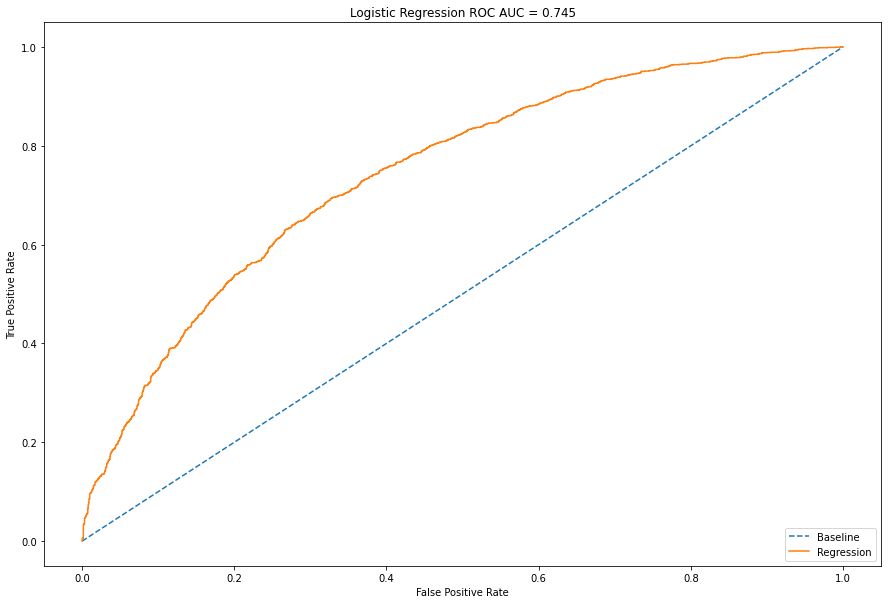

f1_score: 0.68455
accuracy_score: 0.68312
precision_score: 0.677
recall_score: 0.69227
log_loss: 10.94493
roc_auc_score: 0.74461
average_precision_score: 0.6215
brier_score_loss: 0.31688
Confusion matrix:
[[1272  615]
 [ 573 1289]]


0.7446144887542501

In [42]:
# c Penalty 0.7447071642993863 - без нее 0.74498669852976

logModel = LogisticRegression(penalty='l2', class_weight='balanced', max_iter=800, solver = 'liblinear', C = 21.544346900318832)
logModel.fit(X_train, y_train)

#logModel = LogisticRegression(max_iter = 10000)
#logModel.fit(X_train, y_train)

y_pred = logModel.predict(X_test)

probs = logModel.predict_proba(X_test)
prob = probs[:,1]
    
scores(y_test, y_pred, prob)

In [43]:
train_data

,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,foreign_passport,...,work_address_2,work_address_3,car_ct_0,car_ct_1,car_ct_2,mult_address_2,mult_address_3,mult_address_4,mult_address_5,mult_address_6
36349,2,1,0.877170,0.000000,0,0.422511,0.173765,50,0.418348,0,...,1,0,0,0,1,0,1,0,0,0
36350,2,0,0.836491,0.000000,0,0.547101,0.347531,50,0.426176,0,...,0,1,1,0,0,0,0,0,1,0
36351,2,1,0.139279,0.311543,0,0.579560,0.173765,80,0.492305,1,...,1,0,0,1,0,0,1,0,0,0
36352,2,0,0.748648,0.000000,0,0.409772,0.275412,50,0.333251,0,...,0,1,1,0,0,0,0,0,1,0
36353,4,1,0.667639,0.000000,1,0.622291,0.173765,60,0.492305,1,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110107,3,1,0.410597,0.000000,0,0.517502,0.403471,40,0.465908,0,...,0,1,1,0,0,0,0,0,1,0
110127,2,0,0.539118,0.000000,0,0.634436,0.347531,60,0.465908,0,...,0,0,1,0,0,1,0,0,0,0
110128,2,1,0.558736,0.000000,0,0.515472,0.347531,70,0.566263,0,...,0,1,0,0,1,0,0,0,1,0
110135,4,0,0.717183,0.000000,0,0.618557,0.403471,30,0.391952,0,...,0,1,1,0,0,0,0,0,1,0


In [44]:
test_data

,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,foreign_passport,...,work_address_2,work_address_3,car_ct_0,car_ct_1,car_ct_2,mult_address_2,mult_address_3,mult_address_4,mult_address_5,mult_address_6
0,4,1,0.258588,0.000000,0,0.353707,0.347531,50,0.566263,0,...,1,0,0,0,1,0,1,0,0,0
1,2,0,0.498440,0.508104,0,0.554233,0.275412,50,0.232908,0,...,1,0,1,0,0,0,1,0,0,0
2,3,1,0.700993,0.000000,0,0.505509,0.173765,50,0.492305,1,...,1,0,0,0,1,0,1,0,0,0
3,2,1,0.793726,0.000000,0,0.326958,0.173765,40,0.410073,0,...,1,0,1,0,0,0,1,0,0,0
4,4,0,0.477331,0.000000,0,0.297327,0.000000,80,0.693017,0,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,2,0,0.455674,0.196562,0,0.491484,0.347531,50,0.391952,0,...,0,1,1,0,0,0,0,0,1,0
36345,4,0,0.903226,0.000000,0,0.347981,0.347531,60,0.766977,0,...,1,0,0,0,1,0,1,0,0,0
36346,4,1,0.312396,0.311543,0,0.701774,0.173765,50,0.592660,0,...,1,0,1,0,0,0,1,0,0,0
36347,3,0,0.201066,0.196562,0,0.622900,0.275412,80,0.492305,0,...,0,1,1,0,0,0,0,0,1,0


In [45]:
probs_sub = logModel.predict_proba(test_data)
probs_sub = probs_sub[:,1]

submission = pd.concat([prediction.client_id,pd.Series(probs_sub,name='default')],axis=1)
submission.to_csv('submission.csv', index=False)

In [46]:
submission

,client_id,default
0,74835,0.201171
1,17527,0.853422
2,75683,0.340153
3,26883,0.349098
4,28862,0.133641
...,...,...
36344,83775,0.796457
36345,106254,0.112869
36346,81852,0.834340
36347,1971,0.642999
